## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [11]:
import matplotlib
matplotlib.use('QtAgg')
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

C:\Users\Hans\AppData\Local\Temp\ipykernel_23112\3597087069.py:2: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('QtAgg')


In [12]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [13]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [14]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [23]:
# Change to full precision
waveglow_path = 'waveglow_256channels_universal_v5_updated.pt'
waveglow = torch.load(waveglow_path)['model']

waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [44]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

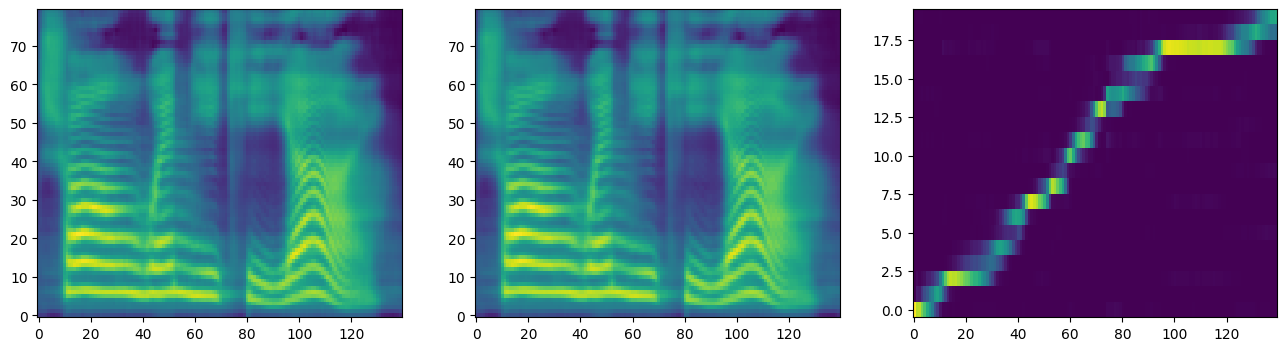

In [45]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [46]:
# change to full precision
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet.type(torch.float32), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [47]:
# audio_denoised = denoiser(audio, strength=0.01)[:, 0]
# ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 